In [1]:
%matplotlib inline
# %matplotlib qt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from qutip import *
import random
import time

import matplotlib.animation as animation
from IPython.display import HTML
from scipy import optimize
import sys
from os import listdir
from os.path import isfile, join


In [104]:
##
#Functions for generating, interpreting, and plotting nodes
##
lattice_param=0.57746273472

class Node:
    def __init__(self,ind,coord,pairs,err):
        self.id = ind
        #Lattice and cartesian coordinate
        self.coord = coord
        self.pairs = pairs
        self.ngbrs = None
        #Conditionally adds random error such that hypotenuse of dx,dx=1
        self.dx = np.random.rand()*err
        self.dy = np.sqrt(err**2-self.dx**2)

        self.x,self.y = transform(coord,0,0)
        #Transformed x and why
        self.xdx = self.x+ self.dx/lattice_param
        self.ydy = self.y+ self.dy/lattice_param
        #OG Distance for calculations later
        self.dist = np.sqrt(self.x**2+self.y**2)
        #Center of Mass
        self.comx = 0
        self.comy = 0
theta = np.pi/6

#Converting lattice location to cartesian coordinates
def transform(coord,dx,dy):
    x=round(coord[1]*np.sin(theta)+coord[0]+ coord[2]*(1/3)*(1+np.sin(theta)),3)
    y=round(coord[1]*np.cos(theta)         + coord[2]*(1/3)*(np.cos(theta)),3)
    return x-dx,y-dy

#Plots a table of nodes plots with transparency for fancy plotting, C plots colors for representing. C is in order of node id 
def plotNodes(ax,fig,nodes,t=0,C=None):
    coords = []
    values = []
    vmax = np.max(np.absolute(C))
    for ID,node in nodes.items():
        x1,y1 =  transform(node.coord,node.comx,node.comy)
        #Plots C value at node site
        try:
            if C.any():
                ax.scatter(x1, y1,c=(C[node.id]), cmap='RdBu',s=500,vmin=-vmax,vmax=vmax,zorder=100)
        except:
            if C:
                ax.scatter(x1, y1,c=(C[node.id]), cmap='RdBu',s=500,vmin=-vmax,vmax=vmax,zorder=100)
        #Plots connections between nodes
        for pair in node.pairs:

            x2,y2 = transform(pair[1],node.comx,node.comy)
           
            if type(pair[2]) is int:
#                 ax.plot([x1,x2],[y1,y2],color=plt.cm.inferno(1-t),linewidth=11,label=str(node.id),alpha=1-t,zorder=1)
                ax.plot([x1,x2],[y1,y2],color="black",linewidth=4.5,label=str(node.id),alpha=.6-t,zorder=2)

            else:
                if np.imag(pair[2])>0:
                    ax.arrow(x1,y1,x2-x1,y2-y1,length_includes_head=True,color="red",linewidth=3,head_width=.02,alpha=.6-t,zorder=2)
#                     ax.arrow(x1,y1,x2-x1,y2-y1,length_includes_head=True,color=plt.cm.afmhot(1-t),linewidth=10,head_width=.02,zorder=1)
                else:
                    ax.arrow(x2,y2,x1-x2,y1-y2,length_includes_head=True,color="red",linewidth=3,head_width=.02,alpha=.6-t,zorder=2)
#                     ax.arrow(x1,y1,x2-x1,y2-y1,length_includes_head=True,color=plt.cm.afmhot(1-t),linewidth=10,head_width=.02,zorder=1)

In [88]:
##
#Functions for generating adjacency matrices from sets of nodes
##

#Generates an adjacency matrix from a list of nodes
def genAdjMatrix(dim,nodes):
    matrix = np.array([np.zeros(dim,dtype=np.clongdouble) for i in range(dim)])
    x=0
    y=0
    for ind, node in nodes.items():
        x+=node.x
        y+=node.y
        if node.pairs:
            n1 = node
            for pair in node.pairs:
                if str(pair[1]) in nodes:
                    n2 = nodes[str(pair[1])]
                    id1=n1.id
                    id2=n2.id
                    if matrix[id1,id2] == 0.+0.j:
                        #Site i,j gets the connectivity of pair
                        w = pair[2]
                        #Computes potential of possible perturbation
                        if id1!=id2:
                            dist = np.sqrt((n2.x-n1.x)**2+(n2.y-n1.y)**2)
                            alpha = (np.sqrt((n1.xdx-n2.xdx)**2+(n1.ydy-n2.ydy)**2)-dist)/dist**3
                            w+=alpha

                        matrix[id1,id2] = w
                        matrix[id2,id1] = np.conj(w)
                        
    #computes COM so every node can be defined relative to it (for later calclations)
    x/=dim
    y/=dim
    for ind, node in nodes.items():
        node.x-=x
        node.y-=y
        node.comx = x
        node.comy = y

    return np.flip(np.flip(matrix,axis=1),axis=0), nodes

#defining NN and NNN connections of a honeycomb lattice
def tess(x,y,wx,wy,wz,a,P):

    if not a:
        return [[[x,y,0],[x-1,y,1],wx],[[x,y,0],[x,y-1,1],wy],[[x,y,0],[x,y,1],wz],\
            [[x,y,0],[x+1,y,0],+P],[[x,y,0],[x,y+1,0],-P],[[x,y,0],[x-1,y+1,0],+P]]
    else:
        return [[[x,y,1],[x+1,y,0],wx],[[x,y,1],[x,y+1,0],wy],[[x,y,1],[x,y,0],wz],\
            [[x,y,1],[x+1,y,1],-P],[[x,y,1],[x,y+1,1],P],[[x,y,1],[x-1,y+1,1],0-P]]    

#Generating nodes the rotationally asymmetric case (kinda dumb/hacky implementation, will change at some point)
def asymmAdj(dim,wx,wy,wz,P,err):
    nodes = {str([0,0,1]):Node(1,[0,0,1],tess(0,0,wx,wy,wz,True,P),err)}
    for y in range(dim):
        for x in range(dim):
            if not (x==y and y==0):
                if not (x==dim-1 and y==dim-1):
                    nodes[str([x,y,1])] = Node((y*dim+x)*2,[x,y,1],tess(x,y,wx,wy,wz,True,P),err)
                nodes[str([x,y,0])] = Node((y*dim+x)*2+1,[x,y,0],tess(x,y,wx,wy,wz,False,P),err)
    nodes[str([dim-1,dim-1,0])].id-=1
    
    return nodes

#Recursively generating nodes for rotationally symmetric case.
def symmAdj(depth,dim,wx,wy,wz,P,err):
    nodes = {}
    depth -= 1
    
    #initial node
    node_0 = Node(0,[0,0,0],tess(0,0,wx,wy,wz,False,P),err)
    nodes[str([0,0,0])] = node_0

    nodes.update(recurseGenNodes(getNeighbors(node_0),depth,wx,wy,wz,P,err))
        
    return nodes

#Returns all neighbors of a node
def getNeighbors(node):
    return [pair[1] for pair in node.pairs]

#Recursive function for generating nodes. Depth defines how many layers of nodes. #Nodes=3*SUM(depth)+1
#leads to open plaquettes
def recurseGenNodes(nodes_list,depth,wx,wy,wz,P,err):

    currNodes = {}

    for node in nodes_list[:3]:
    
        temp_node = Node(0,node,tess(node[0],node[1],wx,wy,wz,node[2],P),err)
        currNodes[str(node)] = temp_node
        if depth>0:
            currNodes.update(recurseGenNodes(getNeighbors(temp_node),depth-1,wx,wy,wz,P,err))

    return currNodes    
    
#Alternating "on" and "off" starting from edge
def genAdj(depth,symm,dim,wx,wy,wz,P,err):

    nodes = {}
    if symm:
        nodes = symmAdj(depth,dim,wx,wy,wz,P,err)
    else:
        nodes = asymmAdj(dim,wx,wy,wz,P,err)
    
    #Removes excess node connections for which a pair node wasn't created 
    for node,i in zip(nodes.values(),range(lattice_num(symm,dim))):
        if node.pairs:
            remove = []
            for pair in node.pairs:
                if not str(pair[1]) in nodes:
                    remove.append(pair)
            for baddies in remove:
                node.pairs.remove(baddies)
        node.id=i

    return nodes


def ranNum(val):
    return np.random.rand(val)[0]

In [89]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from qutip import *
import random
import time

import matplotlib.animation as animation
from IPython.display import HTML
from scipy import optimize
import sys
from os import listdir
from os.path import isfile, join


##
#Functions for creating and reducing quantum objects. Also defines Hamiltonian parameters
##
np.set_printoptions(linewidth=160)

op2state = [qeye(2),create(2),destroy(2)]
opOnSite = [qeye(2),sigmaz()]

#Block diagonalizing matrices (no longer used, but very efficient!) 
def getBasisFast(index,n):
    num = 0
    for i in range(2,n+2):
        
        if index%2 == 1:
            num += 1
            index -= 1
        index/=2
        
    return num

def choose(n,k):
    c = 1
    for i in range(k+1,n+1):
        c *= i
    for i in range(2,n-k+1):
        c/=i
    return int(c)

def extractBlock(n,val,H=None,s=None):
    size = choose(n,val)
    indices = []
    tot = 0
    for i in range(2**n):
        if getBasisFast(i,n) == val:
            indices.append(i)
            tot += 1
        if tot == size:
            break
    arr = []
    if s:
        arr = np.take(s,indices)
        q = Qobj(arr,dims=[[2 for i in range(val)],[1 for i in range(val)]], shape=(n,1))
    else:
        for i in indices:
            arr.append(np.take(H[i][0],indices))
        q = Qobj(arr,dims = [[2 for i in range(val)] for i in range(2)], shape = (n, n))
    return q

#Generating creation/annihilation operator
def genLadderPair(c,d,size):
    arr = [op2state[int(i==c)+int(i==d)*2] for i in range(size)]
    op = tensor(arr)
    return op

#Generating on site energy
def genOnSite(i,size):
    op = (1/(2**(size)))*tensor([opOnSite[0]+(1-2*int(i==j))*opOnSite[1] for j in range(size)])
    return op

#Generates a single excitation in a an ensemble of coupled 2 level states
def gen2lvlState(n,states):
    Qobj()
    state = basis(2,states[0])
    for i in range(1,n):
        state =tensor(state,basis(2,states[i]))
    return state

#Generates an observation basis of state number n, with number of exciatations num_states
def genBasisArbitrary(n,obs_basis):
    
    obs_list = [qeye(2),.5*(qeye(2)-sigmaz())]
    observables = {}
    for i in range(n):
        key = "".join(np.array([int(i==j) for j in range(n)]).astype("str"))
        observables[key] = extractBlock(n,obs_basis,(tensor([obs_list[int(i==j)] for j in range(n)])))
    return observables

#Generates a single particle basis
def genBasisArbitrarySimple(n):
    observables = {}
    for i in range(n):
        arr = np.array([np.zeros(n) for i in range(n)])
        arr[n-i-1][n-i-1] = 1
        key = "".join(np.array([int(i==j) for j in range(n)]).astype("str"))
        observables[key] = Qobj(arr,dims=[[2 for i in range(n)],[2 for i in range(n)]], shape=(n,n))
    return observables

#Returns the number of lattice sites
def lattice_num(symm,n):
    if symm:            
        return 3*np.sum([i for i in range(n+1)])+1
    else:
        return 2*n**2-2
    
#Generates a Hamiltonian from an adjacency matrix
def genHamiltonianFromAdjMatrix(adj_matrix,M):
    x = len(adj_matrix)
    dims = [2 for i in range(x)]
    H = 0
    for i in range(x):
        for j in range(x):
            if adj_matrix[i][j] != 0:
                H+=adj_matrix[i][j]*genLadderPair(i,j,x)
            if i == j:
                if i%2==0:
                    H+=M*genOnSite(i,x)
                else:
                    H-=M*genOnSite(i,x)
    return H

#Does as described
def convertAdjMatrixToHamiltonian(nodes,adj_matrix,M):
    x = len(adj_matrix)
    m_0 = np.flip([np.array([int((x-i-1)==j)*(1-2*int(node[-2])) for i in range(x)]) for j,node in zip(range(x),nodes)],0)

    adj_matrix = np.add(adj_matrix,np.multiply(M,m_0))
    return Qobj(adj_matrix,dims=[[2 for i in range(x)],[1 for i in range(x)]], shape=(x,x))
    
#Generates a state of occupation at site state_ind in obs_basis amoung lat_sites number of sites
def genReducedState(state_ind,lat_sites,obs_basis,state=None):
    if not state:
        if obs_basis ==1:
            state = gen2lvlState(lat_sites,[int(i==state_ind) for i in range(lat_sites)])
        else:
            arr = [int(i<obs_basis) for i in range(lat_sites)]
            np.random.shuffle(arr)
            state = gen2lvlState(lat_sites,arr)
    
        state = extractBlock(lat_sites,obs_basis,None,state)
    return state

#Generates a single particle at a site of ket length lat_sites
def genStateSimple(state_ind,lat_sites,obs_basis,state=None):
    s=[[(1+1j)*int(i==(lat_sites-state_ind-1))] for i in range(lat_sites)]
    return Qobj(s,dims=[[2 for i in range(lat_sites)],[1 for i in range(lat_sites)]], shape=(lat_sites,1)).unit()

In [113]:
##
#Functions for plotting Hamiltonian information/results
##

ep=.0001

#Calculates response function. Lowkey totally uselyess
def calcResponseFunc(H,omegas,eVals,eVecs,s_i,s_j,s1,s2):

    totals = []
    for w in omegas:
        summ = 0
        for eVal,eVec in zip(eVals,eVecs):
            psi_i=s_i.dag().overlap(eVec)
            psi_j=s_j.dag().overlap(eVec)
            summ+=np.absolute(psi_i*psi_j/(w-eVal+1j*ep))
        totals.append(summ)
        
    plt.plot(omegas,totals)
    plt.title("Response function for site "+str(s1)+" and "+str(s2))
    plt.show()
    return totals

#Plots response function
def plotResponseFunction(eVals,eVecs,lat_sites,obs_basis):
    steps = 2500
    omegas = np.linspace(-1+eVals[0],1+eVals[-1],steps)
    totals = np.zeros(steps)
    for k in range(lat_sites):
        s1=extractBlock(lat_sites,obs_basis,None,gen2lvlState(lat_sites,[int(i==k) for i in range(lat_sites)]))
        for j in range(lat_sites):
            s2 = extractBlock(lat_sites,obs_basis,None,gen2lvlState(lat_sites,[int(i==j) for i in range(lat_sites)]))
            totals+=calcResponseFunc(H,omegas,eVals,eVecs,s1[0],s2[0],j,k)
    plt.plot(omegas,totals)
    plt.scatter(eVals,np.zeros(len(eVals)))
    plt.title("Conductivity")
    plt.show()

#Returns x,y values for nodes. 
def getxy(nodes):
    x = []
    y = []
    for key,value in nodes.items():
        x.append(value.x)
        y.append(value.y)

    return x,y
   
#Preps plot and data for plotting motion of particles
def prepPlot(tlist,nodes,result,style):
    results_by_position = result.expect
    probs = [[] for i in range(len(tlist)-1)]
    for i in range(len(tlist)-1):
        probs[i] = np.array([value[i] for key, value in results_by_position.items()])
    x,y = getxy(nodes)
    
    if style == "vid":
        fig_anim, ax_anim = plt.subplots(ncols=1, sharey=False, figsize=(24,30))

        fig_anim.subplots_adjust(hspace=0.25, left=0.07, right=0.93)

        return x,y,fig_anim,ax_anim,probs
    elif style == "traj":
        
        return x,y,probs
        
#     return probs

#Plots particles' motion
def plotPath(result,tlist,nodes):
#     plt.style.use('dark_background')
    x,y,fig_anim,ax_anim,probs = prepPlot(tlist,nodes,result,"vid")

    def updateHaldane(i):
#         pulse=np.absolute(np.sin(2*np.pi*i/len(tlist)))
        pulse=0
        ax_anim.cla()
        plotNodes(ax_anim,nodes,pulse)

        prob = probs[i]
        plt.axis('off')
        xmin = np.min(x)-1
        xmax = np.max(x)+1
        ymin = np.min(y)-1
        ymax = np.max(y)+1
#         hb = ax_anim.scatter(x, y,c=[1-pulse for j in range(len(prob))], cmap='afmhot',s=28000,vmin=0,vmax=.30,zorder=99)
        hb = ax_anim.scatter(x, y,c=prob, cmap='inferno',s=25000,vmin=0,vmax=.30,zorder=100)
        ax_anim.axis([xmin, xmax, ymin, ymax])
#         cb = fig_anim.colorbar(hb, ax=ax_anim)


    Writer = animation.writers['html']
    writer = Writer(fps=100, metadata=dict(artist='Me'), bitrate=1800)
    animation.FuncAnimation(fig_anim, updateHaldane,frames=len(tlist)-1, interval=1).save(filename, writer=writer)
    plt.clf()
    #Also plots time series of probabilities
    plotTimeSeries(probs)
    return
    
#Plots eigenvectors from simple "ket arrays". Works for single particle basis. Pass high basis  eVecs through findEVecs first
def plotEigenVector(ket_array,o_basis,nodes):
    x,y = getxy(nodes) 

    fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(12,10))
    plotNodes(ax,fig,nodes,0)
    
    xmin = np.min(x)-1
    xmax = np.max(x)+1
    ymin = np.min(y)-1
    ymax = np.max(y)+1
    hb = ax.scatter(x, y,c=ket_array, cmap='inferno',s=4000,vmin=0,zorder=100)
    ax.axis([xmin, xmax, ymin, ymax])
    cb = fig.colorbar(hb, ax=ax)
    plt.show()

#Assigned edginess to evey eigenvalue 
def computeEdgeness(values,nodes):
    edgeness = 0
    for value,node in zip(values,nodes.values()):
        edgeness += value*node.dist
    return edgeness

#Plots time seriies of WF evolution
def plotTimeSeries(probs):
    fig, ax = plt.subplots(ncols=1, sharey=False, figsize=(15,10))
    n = len(probs)
    probs = np.transpose(probs)
    t = len(probs)
    x = [i for i in range(n)]
    for i in range(t):
        ax.scatter(x,probs[i],color=(ranNum(1),ranNum(1),ranNum(1)),label="Site "+str(i))
    ax.legend()

    plt.show()
    plt.clf()

#Shitty periodic fic
def periodicFit(x, a, b):
    return a * np.sin(b * x)

#Computes std of a set of data (probably faster to use numpy)
def computeStdDev(mean,trials):
    diff = [0 for i in range(len(mean))]
    for trial in trials:
        diff += np.absolute(np.subtract(mean,trial))
    return diff/len(trials)

#Attempt at computing tunnelling rate from a periodic fic
def computeTunnelingRate(x,y):
    params, params_covariance = optimize.curve_fit(periodicFit, x, y,
                                               p0=[2, 2])
    return params

#Computes angular velocity of a trajectory. Accounts for particle crossing origin
def calcAngularVel(th):
    p2=2*np.pi
    corrections_list=[]
    
    if th[0]<0:
        th[0]=p2+th[0]
        corrections_list.append(0)
    
    for i in range(1,len(th)):
        if th[i]<0:
            th[i]=p2+th[i]
 
        if np.absolute(th[i]-th[i-1])>np.pi:
            corrections_list.append(i)
    om = np.gradient(th,1)

    for c in corrections_list:
        if(om[c])<0:
            om[c-1]=(np.pi%(-om[c-1]))
            om[c]=(np.pi%(-om[c])) 
        else:
            om[c-1]=-(np.pi%om[c-1])
            om[c]=-(np.pi%om[c])
    om = np.delete(om,-1)
    return om

#Computes the values necessary for the paramscan plots. Produces single values for single trajectories
def calcAngularValues(p_x,p_y,mu_x,mu_y,periods):
    om = calcAngularVel(np.arctan2(p_x,p_y))
    
    I     = np.delete(np.add(np.square(p_x),np.square(p_y)),-1)
    
    p   = np.multiply(om,I)
    
    t = np.absolute(np.delete(np.gradient(p),-1))
    
    return np.average(I),np.average(np.delete(np.absolute(np.gradient(I)),-1)),\
           np.average(om),np.average(np.delete(np.absolute(np.gradient(om)),-1)),\
    np.average(p), np.average(t),np.average(np.add(np.square(mu_x),np.square(mu_y)))  

#Generates position operators. Should end up as R=sum_ij(del_ij|i><j|)
def genPositionObservables(nodes,size,dtp):
    
    x = [np.zeros(size,dtype=dtp) for i in range(size)]
    y = [np.zeros(size,dtype=dtp) for i in range(size)]
    
    return x,y

# Recursively identifies neighbors of a given node from a list of nodes
def collectNeighbors(nodes,node,it):
    
    nodeIDs = []
    
    for pair in node.pairs:
        if pair[0][2] != pair[1][2]:
            ngbr = nodes[str(pair[1])]
            nodeIDs.append(ngbr.id)
            if it>0:
                nodeIDs+=collectNeighbors(nodes,ngbr,it-1)
    #Converts collected neighbors to a dict to eliminate duplicates
    return list(dict.fromkeys(nodeIDs))

#Finds the neighbors of each node to depth TOPORANGE
def setNeighbors(nodes):
    
    for key,node in nodes.items():
        ngbr_sts = collectNeighbors(nodes,node,TOPORANGE-1)
        if node.id in ngbr_sts:
            ngbr_sts.remove(node.id)
        nodes[key].ngbrs = ngbr_sts

#Computes position operators X,Y for computng Chern marker or Bott Index
def computePositionOperators(nodes,op,bott,dtp,states=None):
    
    
    size = len(nodes)
    x,y=genPositionObservables(nodes,size,dtp)
    
    #Computes Bott index (always zero)
    if bott:
        for node in nodes.values():
            i = size-node.id-1
            x[i][i] = np.complex(np.cos(2*np.pi*node.xdx),np.sin(2*np.pi*node.xdx))
            y[i][i] = np.complex(np.cos(2*np.pi*node.xdx),np.sin(2*np.pi*node.xdx))
        x = Qobj(x,dims=[[2],[2]], shape=(size,size))
        y = Qobj(y,dims=[[2],[2]], shape=(size,size))
    
        U = op*x*op
        V   = op*y*op


        return U,V
    
    #Topological chern marker
    else:
        #Fills x,y along diagonal 
        for node in nodes.values():
            i = node.id
            x[i][i] = node.x
            y[i][i] = node.y
            
        #Generates X,Y templates
        X = [[0 for i in range(size)] for i in range(size)] 
        Y = [[0 for i in range(size)] for i in range(size)] 
                
        for node in nodes.values():
            i = node.id
            #Computes X for "close neighbors" adjustable using TOPORANGE
            for ngbr in node.ngbrs:
                j = ngbr
                X_temp = 0; Y_temp = 0
                #Computes projection operators using dummy variable
                for node_prime in nodes.values():
                    
                    k = node_prime.id
                    val = states[i].dag()*op*states[k]*states[k].dag()*op*states[j]
                    X_temp += np.around(x[k][k],3)*val[0][0][0]
                    Y_temp += np.around(y[k][k],3)*val[0][0][0]
                #X/Y are 2D arrays storing the operator value for sites i and j
                X[i][j] = X_temp
                Y[i][j] = Y_temp

            #Plotting nodes if you wish
#             fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(12,10))
#             plotNodes(ax,fig,nodes,0,np.absolute(X[i]))
#             plt.show()

        return X,Y

#Quickly generates array of single particle states for efficient projector compuatation
def genStateArray(nodes,size):
    arr = {}
    
    for node in nodes.values():
        
        for node in nodes.values():
            arr[node.id] = (genStateSimple(node.id,size,1))

    return arr
            
#Compute eVals if none are given           
def isEVals(eVals,eVecs,H):
    try:
        if not eVals.any():
            e = H.eigenstates()
            eVals = e[0]
            eVecs = e[1]
    except:
        if not eVals:
            e = H.eigenstates()
            eVals = e[0]
            eVecs = e[1]

    return eVals,eVecs

#Attempts to compute bott index
def computeBottIndex(nodes,H,basis,size,eVals=None,eVecs=None):
    eVals,eVecs = isEVals(eVals,eVecs,H)
    operator = [np.zeros(size,dtype=np.clongdouble) for i in range(size)]

    for eva,eve in zip(eVals,eVecs):
        if eva < -1.1:
            operator = np.add(operator,eve*eve.dag()) 
    U,V = computePositionOperators(nodes,Qobj(operator,dims=[[2],[2]], shape=(size,1)),True,np.clongdouble)
    
    A=V*U*V.dag()*U.dag()
    B=np.imag(np.trace(np.log(A)))
    return B

from decimal import Decimal

def format_e(n):
    a = '%E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]


#Attempts to compute topological marker as outlined in PHYSICAL REVIEW B 84, 241106(R) (2011)
def computeTopologicalMarkers(nodes,H,basis,size,eVals=None,eVecs=None):

    eVals,eVecs = isEVals(eVals,eVecs,H)

    size = len(eVals)
    
    #Collects all node neighbors to depth TOPORANGE
    setNeighbors(nodes)
    
    #Sets groundstate projector
#     print(eVecs[0].unit())
    GS=0
    for i in range(int(size/2)):
        GS += eVecs[i].proj()
#     print(GS)
#     for node in nodes.values():
#         print(node.id,node.x,node.y)
#     findEigenVectors([eVecs[0]],[eVals[0]],basis,nodes,True)
    #Generates states
    states = genStateArray(nodes,size)    
    
    X,Y = computePositionOperators(nodes,GS,False,np.double,states)
    
    #Array of Chern Markers 
    C = np.zeros(len(nodes))
    
    #summming over commutators
    for node in nodes.values():
        i = node.id
        C_0 = 0
        for ngbr in node.ngbrs:
            C_0 += X[i][ngbr]*Y[ngbr][i]-Y[i][ngbr]*X[ngbr][i]
        try:
            C[i]=(-2*np.pi*1j*C_0)
        except:
            C[i]=(-2*np.pi*C_0)
    
    fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(12,10))
    plotNodes(ax,fig,nodes,0,C)
    plt.show()
    return C
TOPORANGE = 4
np.set_printoptions(precision=1, threshold=None, edgeitems=None, linewidth=250, suppress=None, nanstr=None, infstr=None, formatter=None, sign=None, floatmode=None)

<Figure size 1080x1440 with 0 Axes>

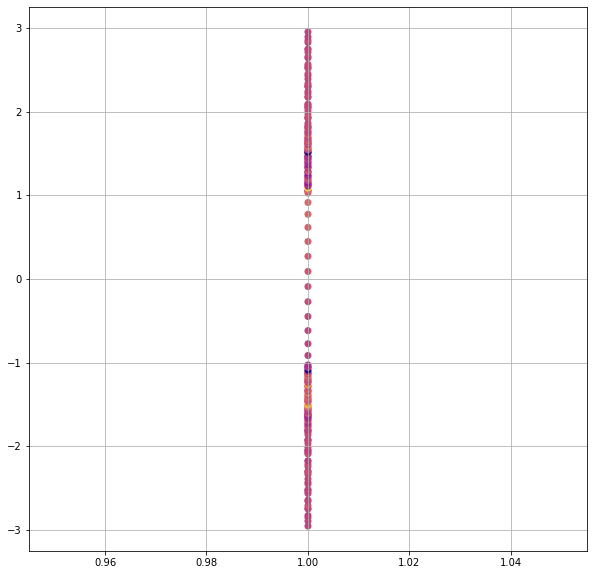

/home/bernienlab/.local/lib/python3.6/site-packages/ipykernel_launcher.py:365: ComplexWarning: Casting complex values to real discards the imaginary part


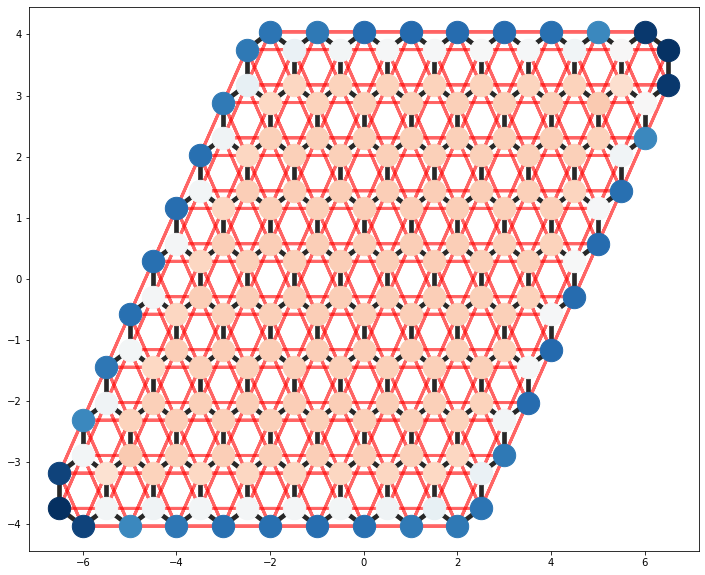

In [119]:
C = computeTopoProperties(np.pi/2,1*.27,0,10,1,0,.27)

<Figure size 1080x1440 with 0 Axes>

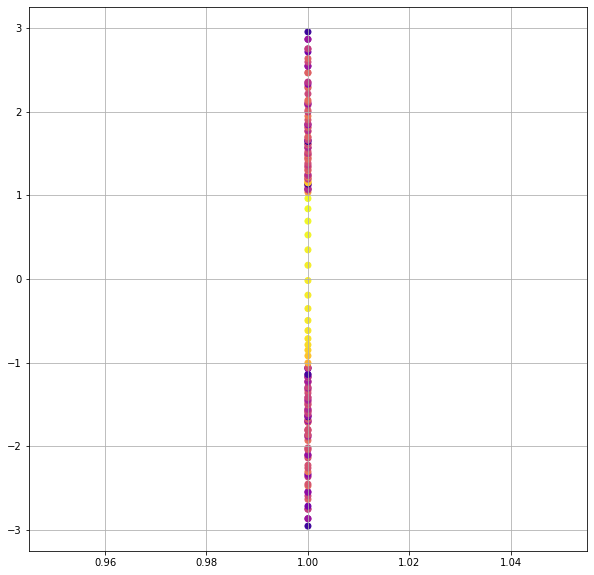

/home/bernienlab/.local/lib/python3.6/site-packages/ipykernel_launcher.py:365: ComplexWarning: Casting complex values to real discards the imaginary part


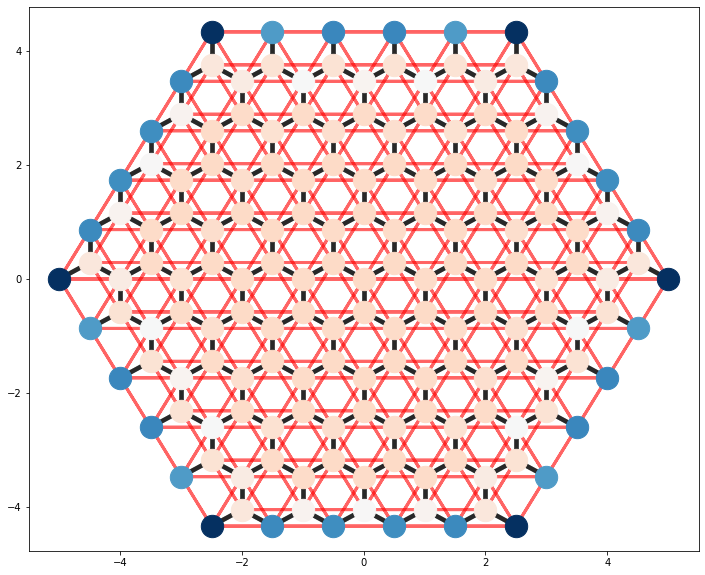

In [122]:
C = computeTopoProperties(np.pi/2,1*.27,1,10,1,0,.27)

In [121]:
print(C)

[ 1.7  0.   1.5  0.1  1.1  0.   1.2  0.   1.3  0.   1.3  0.   1.3  0.1  1.3  0.1  1.2  1.2  1.2  0.   1.5 -0.4 -0.3 -0.4 -0.4 -0.4 -0.3 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.3  1.2  0.1  0.1  1.1 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4
 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4  1.3  0.   0.   1.2 -0.4 -0.3 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4  1.3  0.   0.   1.3 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4  1.3
  0.   0.   1.3 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4  1.3  0.   0.   1.3 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4  1.3  0.   0.1  1.3 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4
 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4  1.1  0.1  0.1  1.2 -0.4 -0.3 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.3 -0.4  1.6 -0.   1.2  1.2  1.2  0.1  1.3  0.   1.3  0.   1.3  0.   1.3  0.   1.3  0.   1.1  0.1  1.6
 -0.   1.6]


In [123]:
C

array([-4.0e-01, -4.1e-01, -4.0e-01, -4.0e-01, -4.1e-01, -4.0e-01, -4.0e-01, -4.1e-01, -4.0e-01, -4.0e-01, -4.1e-01, -4.0e-01, -4.0e-01, -4.1e-01, -3.9e-01, -4.1e-01, -4.0e-01, -4.1e-01, -3.9e-01, -4.1e-01, -4.0e-01, -4.0e-01, -4.1e-01, -3.9e-01,
       -4.1e-01, -4.0e-01, -4.1e-01, -4.0e-01, -4.0e-01, -4.1e-01, -4.0e-01, -4.1e-01, -3.1e-01, -3.6e-01, -4.1e-01, -3.5e-01, -4.1e-01, -3.6e-01, -4.1e-01, -3.5e-01, -4.1e-01, -3.1e-01, -4.1e-01, -3.5e-01, -4.1e-01, -3.5e-01, -4.1e-01, -3.1e-01,
       -3.6e-01, -4.1e-01, -3.5e-01, -4.1e-01, -3.6e-01, -4.1e-01, -3.5e-01, -4.1e-01, -3.1e-01, -4.1e-01, -3.1e-01, -3.6e-01, -4.1e-01, -3.6e-01, -4.1e-01, -3.1e-01, -3.9e-01, -1.7e-01, -3.9e-01, -3.9e-01,  2.0e-03, -4.1e-01, -3.9e-01, -3.9e-01,
       -5.6e-02, -4.1e-01, -3.9e-01, -3.9e-01,  2.0e-03, -3.9e-01, -1.7e-01, -3.9e-01,  1.9e-03, -3.9e-01, -5.6e-02, -3.9e-01,  1.9e-03, -3.9e-01, -1.7e-01, -3.9e-01, -3.9e-01,  1.9e-03, -4.1e-01, -3.9e-01, -3.9e-01, -5.6e-02, -4.1e-01, -3.9e-01,
       -3.9e

In [23]:
def printEigenspectrum(P,M,w1,w2,w3,t1t2,err,symm,atom_sets):
    eVals=[]
    eVecs=[]
    x = []
    edge_vals = []
    site_num = None
    node_distances = None
    site_num = lattice_num(symm,atom_sets)
    obs_basis=1

    nodes,site_num,H,proj,eVals_temp,eVecs_temp=prepHamiltonian(symm,atom_sets,obs_basis,1,1,1,t1t2*np.complex(np.cos(P),np.sin(P)),M,err,True)
    eVal,eVec,edgeness = findEigenVectors(eVecs_temp,eVals_temp,proj,nodes,False)
    eVals.append(eVal)
    edge_vals.append(edgeness)
    x.append([obs_basis for j in range(len(eVal))])
    plt.figure(figsize=(15,20))   
    fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(10,10))
    plt.grid()
    for x_i,eVal,edge_val in zip(x,eVals,edge_vals):
        ax.scatter(x_i,eVal,c=edge_val,cmap="plasma")
#     plt.figure(figsize=(15,20))   
#     fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(10,10))
#     plt.ylim(top=.5,bottom=-.5)
#     for x_i,eVal,edge_val in zip(x,eVals,edge_vals):
#         ax.scatter(x_i,eVal,c=edge_val,cmap="plasma")
    plt.show()
    return nodes,site_num,H,proj,eVals_temp,eVecs_temp

#Reduces basis>1 eigenvectors to arrays with length=#sites for plotting
def findEigenVectors(eVecs,eVals,o_basis,nodes,plot):
    evalsList = []
    eVecsList = []
    edgeness = []
    for i in range(eVecs[0].shape[0]):
        orth = True
        ket_array = []

        for key,value in o_basis.items():
            ket_array.append(np.real((value*eVecs[i]).norm())**2)
        if np.sum(ket_array)>0.01:
            evalsList.append(eVals[i])
            edgeness.append(computeEdgeness(ket_array,nodes))
            if plot:
                print(eVals[i])
                plotEigenVector(ket_array,o_basis,nodes)
                plt.show()
        eVecsList.append(ket_array)

    return evalsList,eVecs,edgeness/np.sum([np.sum(edge_list) for edge_list in edgeness])


#Generates average location and err of a trajectories 
def genAvgLoc(probs,nodes,plot,runtime):
    
    loc_x = [node.x for node in nodes.values()]
    loc_y = [node.y for node in nodes.values()]
    
    size = len(loc_y)
    
    probs_x = []
    probs_y = []
    err_x = []
    err_y = []
    
    for prob in probs:
        p_x = np.multiply(loc_x,prob)
        p_y = np.multiply(loc_y,prob)
        err_x.append(np.std(p_x))
        err_y.append(np.std(p_y))
        probs_x.append(np.sum(p_x))
        probs_y.append(np.sum(p_y))

    err_x=err_x[:int(runtime/4)]
    err_y=err_y[:int(runtime/4)]
    
    if plot:
        fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(12,10))
        plotNodes(ax,nodes,.3)
#         ax.plot(probs_x,probs_y,color='#000000',linewidth=4)
        ax.scatter(probs_x,probs_y,color="black")
        plt.show()
    return probs_x,probs_y,err_x,err_y

#Generates a trajectory
def genTrajectory(result,tlist,nodes,runtime,plot=True):
    x,y,probs = prepPlot(tlist,nodes,result,"traj")
    plt.clf()
    return genAvgLoc(probs,nodes,plot,runtime)




In [30]:
##
#Main/running and manipulating Hamiltonians  
##

#Prepares and block diagonalizes a Hamiltonian (if necessary)
def prepHamiltonian(symm,atom_order,obs_basis,w1,w2,w3,P,M,err,diagonalize):
    lat_sites = lattice_num(symm,atom_order)
    adj_matrix,nodes = genAdjMatrix(lat_sites,genAdj(atom_order,symm,atom_order,w1,w2,w3,P,err)) 
    H_red = None; proj_red = None
    if obs_basis!=1:
        H = genHamiltonianFromAdjMatrix(adj_matrix,M)
        H_red = extractBlock(lat_sites,obs_basis,H)
        proj_red = genBasisArbitrary(lat_sites,obs_basis)
    
    else:
        H_red = convertAdjMatrixToHamiltonian(nodes,adj_matrix,M)
        proj_red = genBasisArbitrarySimple(lat_sites)
    
    if diagonalize:
        eVecs = H_red.eigenstates()
        return nodes,lat_sites,H_red,proj_red,eVecs[0],eVecs[1]
    else:
        return nodes,lat_sites,H_red,proj_red

#Creaes a state with defined parameters
def createState(state_ind,lat_sites,obs_basis,state=None):
    if obs_basis!=1:
        return genReducedState(state_ind,lat_sites,obs_basis,state)
    else:
        return genStateSimple(state_ind,lat_sites,obs_basis,state)

#Runs hamiltonian for time time with step steps in obs_basis using proj
def runHamiltonian(lat_sites,state_ind,H,proj,obs_basis,state=None,time=0,step=0,):
    
    tlist = np.linspace(0,time,step)
    state = createState(state_ind,lat_sites,obs_basis,state)
    result = sesolve(H,state,tlist,proj)
    plotPath(result,tlist,nodes)
#     plotResponseFunction(eVals,eVecs,lat_sites,obs_basis)
    
    return

#Computes eigenspectrum, then computes topological property
def computeTopoProperties(phi,m,symm,sets,obs_basis,err,t1t2):
    nodes,site_num,H,proj,eVals,eVecs=printEigenspectrum(phi,m,1,1,1,t1t2,err,symm,sets)
    size= lattice_num(symm,sets)

#     B_i = computeBottIndex(nodes,H,basis,size,eVals,eVecs)
    B_i = computeTopologicalMarkers(nodes,H,proj,size,eVals,eVecs)
    return B_i

#Scans parameter space in a given range to visualize topological behavior
def scanEdgeBehavior(phi_range,m_range,symm,sets,obs_basis,state_ind,err,t1t2):
    periods = 8*np.pi           #How many time periods
    step = periods*10
    tlist = np.linspace(0,periods,int(step))
    state = createState(state_ind,lattice_num(symm,sets),obs_basis)
    
    I_bar=[]
    dI_bar=[]
    om_bar=[]
    dom_bar=[]
    p_bar=[]
    t_bar=[]
    mu_bar=[]
    
    b_index = []
    
    size=len(phi_range)
    nodes,site_num,H,proj=prepHamiltonian(symm,sets,obs_basis,1,1,1,0+1j,0,err,False)
    pnum = H.shape[0]
    phi_0 = np.imag(H.copy())*t1t2
    
    m_0 = np.flip([np.array([int((pnum-i-1)==j)*(1-2*int(node[-2])) for i in range(pnum)]) for j,node in zip(range(pnum),nodes)],0)
    H=np.real(H)
    writeHamTemplateToFile(H,phi_0,m_0,proj,"16atomTemplate1Basis")
    
    for i,phi in zip(range(size),phi_range):
        H_phi = np.add(H,np.multiply(phi_0,np.complex(np.cos(phi),np.sin(phi))))
        I_bar.append([])
        dI_bar.append([])
        om_bar.append([])
        dom_bar.append([])
        p_bar.append([])
        t_bar.append([])
        mu_bar.append([])
        
        b_index.append([])
        
        for j,m in zip(range(size),m_range):
            H_hal = Qobj(np.add(H_phi,m*m_0),dims=[[2],[2]],shape=(pnum,num))
#             print(H_hal)
#             print(state)
#             print(proj)
#             p_x,p_y,mu_x,mu_y = genTrajectory(sesolve(H_hal,state,tlist,proj),tlist,nodes,step,True)
#             I_i,dI_i,om_i,dom_i,p_i,t_i,mu_i = calcAngularValues(p_x,p_y,mu_x,mu_y,periods)
#             I_bar[-1].append(I_i)
#             dI_bar[-1].append(dI_i)
#             om_bar[-1].append(om_i)
#             dom_bar[-1].append(dom_i)
#             p_bar[-1].append(p_i)
#             t_bar[-1].append(t_i)
#             mu_bar[-1].append(mu_i)
            b_index[-1].append(computeBottIndex(nodes,H_hal,proj,len(H_hal[0])))
            sys.stdout.write("\r" + str((i*size+j)/size**2))
            sys.stdout.flush()
#     return I_bar,dI_bar,om_bar,dom_bar,p_bar,t_bar,mu_bar
    return b_index

def perturbScanEdgeBehavior(phi_range,m_range,sym,sets,obs_basis,ind,err,takes,t2):
    error_plots = {}
    for er in err:
        takes_f = takes
        I=[]
        dI=[]
        om=[]
        dom=[]
        p=[]
        t=[]
        mu=[]
        print("\nError " +str(er)+'\n')
        if er==0:
            takes_f = 1
        for take in range(takes_f):
            
            I_i,dI_i,om_i,dom_i,p_i,t_i,mu_i = scanEdgeBehavior(phi_range,m_range,sym,sets,obs_basis,ind,er,t2)
            I.append(I_i)
            dI.append(dI_i)
            om.append(om_i)
            dom.append(dom_i)
            p.append(p_i)
            t.append(t_i)
            mu.append(mu_i)
        error_plots[er] = [np.average(I,0),np.average(dI,0),np.average(om,0),np.average(dom,0),np.average(p,0),np.average(t,0),np.average(mu,0)]
    return error_plots

def perturbTrajectory(phi,m,takes,err,symm,sets,obs_basis,state_ind):
    state=None
    p_x = [0 for i in range(1500-1)]
    p_y = [0 for i in range(1500-1)]
    x_trials=[]
    y_trials=[]
    nodes=genAdj(symm,sets,1,1,1,phi*1j,err)

    for i in range(takes):
        nodes,site_num,H,proj=prepHamiltonian(symm,sets,obs_basis,1,1,1,phi*1j,m,err,False)
        periods =4           #How many time periods
        step = 500
        tlist = np.linspace(0,periods,step)
        state = genReducedState(state_ind,lattice_num(symm,sets),obs_basis)
        x_temp,y_temp = genTrajectory(sesolve(H,state,tlist,proj),tlist,nodes,True)
        p_x =np.add(p_x,x_temp)
        p_y =np.add(p_y,y_temp)
        print(calcAngularVelocity(p_x,p_y,periods))
        x_trials.append(x_temp)
        y_trials.append(y_temp)
    fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(24,30))

    plotNodes(ax,nodes,t=.3)

    x = np.divide(p_x,takes)
    y = np.divide(p_y,takes)
    xerr = computeStdDev(x,x_trials)
    yerr = computeStdDev(y,y_trials)
    ax.errorbar(x,y,xerr,yerr,ecolor='b',linewidth=.5,alpha=.7)
    ax.plot(x,y,linewidth=4,color='k')

    plt.show()            

def writeHamTemplateToFile(nn,nnn,m,ops,name):
    f = open(str(name)+".txt", "a")
    f.write(str(2)+'\n') #First line is dim
    f.write(str(len(nn))+'\n') #Second line is shape
    for operator in [nn,nnn,m]: #Prints nn, real nnn, imaginary nnn, m
        for row in operator:
            for elem in row:
                f.write(str(elem)+' ')
            f.write('\n')
        f.write('\n')
    for key,value in ops.items():
        f.write(str(key)+"\n")
        for row in value:
            for elem in row:
                f.write(str(elem)+' ')
            f.write("\n")
        f.write("\n")
    f.close()

0.9999751.8767150848773198e-12 -1.5913925688095827e-12


TypeError: zip argument #1 must support iteration

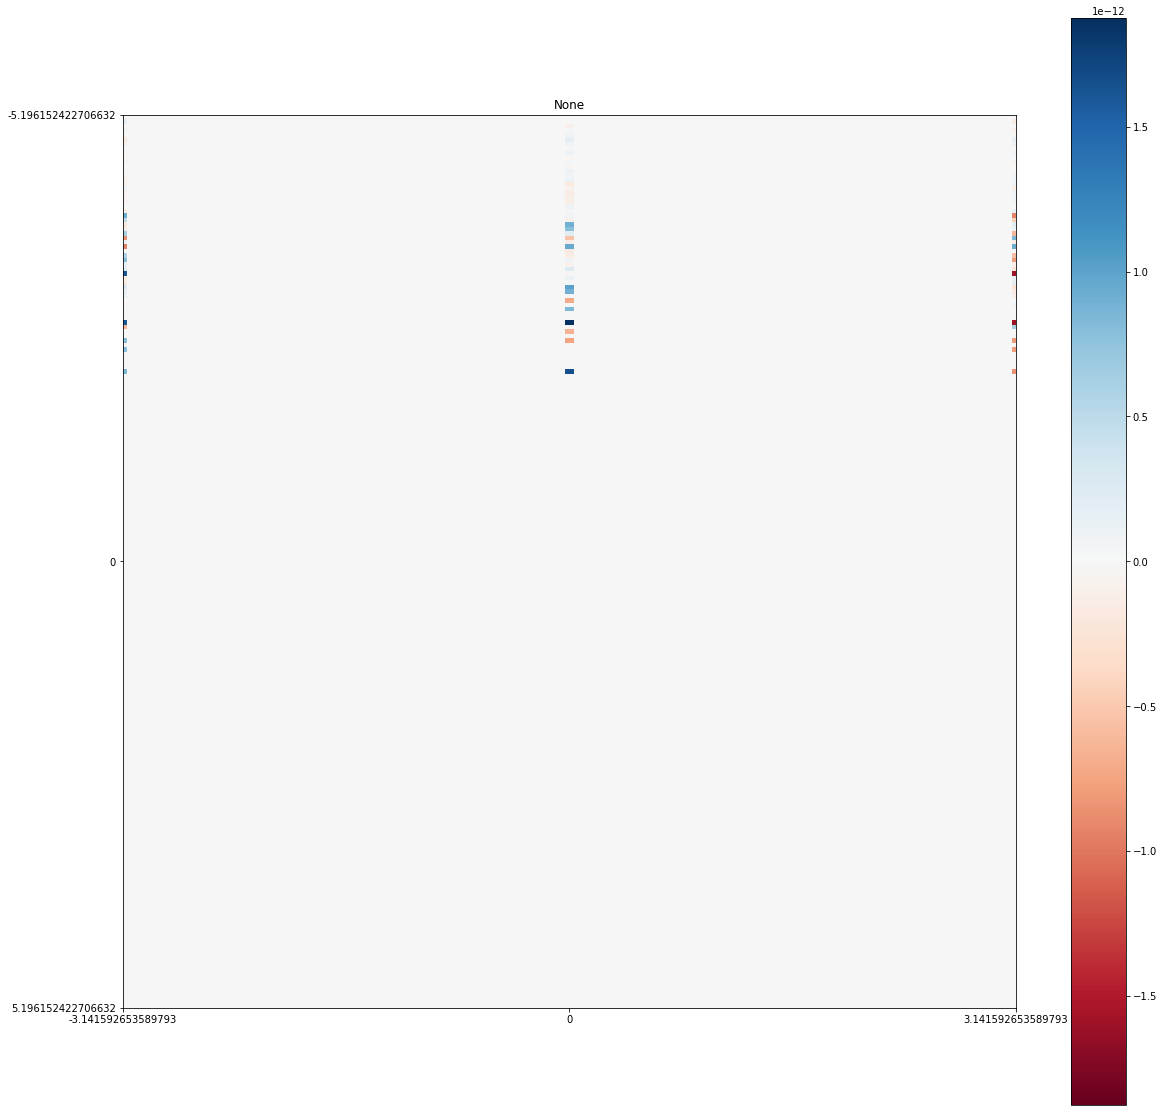

In [196]:
div = 200
phi_range = np.sort(np.append(np.linspace(-np.pi,np.pi,div-1),0))
m_range = np.linspace(-3*np.sqrt(3),3*np.sqrt(3),div)
b4 = scanEdgeBehavior(phi_range,m_range,1,5,1,45,0,-.27)
plotHeatMap(b4,"None",div,True,0,0)

In [9]:

def plotHeatMap(values,title,div,vel,px,py,vmin=None,vmax=None):
#     if f:
#         f = open(str(title)+".txt", "a")
#         f.write("I\n")
#         for I in values:
#             for II in I:
#                 f.write(str(II)+" ")
#             f.write('\n')
#         f.close()
    mval = np.max((values))
    minval = np.min((values))
#     mval = 0.031062802740375404
    print(mval,minval)
#     print(title,mval)
    values = np.transpose(values)
    fig, ax= plt.subplots(ncols=1, sharey=False, figsize=(20,20))
    ax.set_title(title)
    im=None
    if not vel:
        if not vmax:
            im = ax.imshow(values,cmap="inferno")
        else:
            im = ax.imshow(values,cmap="inferno",vmin=-mval,vmax=mval)
    else:
        im = ax.imshow(values,cmap='RdBu',vmin=-mval, vmax=mval)
    fig.colorbar(im, ax=ax)
    tic = div/2
    # We want to show all ticks...
    ax.set_xticks(np.arange(-.5,div,tic))
    ax.set_yticks(np.arange(-.5,div,tic))
    # ... and label them with the respective list entries
    ax.set_xticklabels([-np.pi,0,np.pi])
    ax.set_yticklabels([-3*np.sqrt(3),0,3*np.sqrt(3)])
    for x,y in zip(px,py):
        ax.scatter((1+(x)/np.pi)*tic,(1+(y)/(3*np.sqrt(3)))*tic)
    plt.show()

def writeResults(data,dtype,file):
    fname = str(file)
    f = open(fname+".txt", "a")
    f.write(str(dtype))
    f.write('\n'+str(len(data))+'\n')
    for dd in data:
        for d in dd:
            f.write(str(d)+' ')
        f.write('\n')
    f.write('\n')
    f.close()
    
    
    
def showResults(I,dI,om,dom,p,t,mu,name,x,y):
   
#     plotHeatMap(I, "Time Averaged Moment of Inertia",div,False,[],[])
    writeResults(I,"MoI",name)
    
#     plotHeatMap(dI,"Time Averaged Change in Moment of Inertia",div,False,[],[])
    writeResults(dI,"dMoI",name)
    
#     plotHeatMap(om,"Time Averaged Angular Velocity",div,True,[],[],-1,1)
    writeResults(om,"AV",name)

#     plotHeatMap(dom,"Time Averaged Absolute Angular Acceleration",div,False,[],[])
    writeResults(dom,"dAV",name)
    
    plotHeatMap(p,"Time Averaged Angular Momentum",div,True,[x],[y],-0.01829168393695758,0.01829168393695758)
    writeResults(p,"p",name)

    plotHeatMap(t,"Time Averaged Torque",div,False,[x],[y],0,0.0014560637055729812)
    writeResults(t,"t",name)
#     
    plotHeatMap(mu,"Time Averaged Particle Variance",div,False,[],[],0,0.02813009323778883)
    writeResults(mu,"var",name)

def readParticleData(pnum,file,mypath):

    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    f=open(mypath+"/"+str(file))
    a=[]
    title_list=[]
    while(1):
        title_list.append(str(f.readline()))
        try:
            size =int(f.readline())
        except:
            f.close()
            break
        temp_list = []
        while(1):
            line = list(map(float,f.readline().split(' ')[:-1]))

            if not len(line):
                break
            temp_list.append(np.array(line))
        a.append(temp_list)
    return a

In [ ]:
div = 225
phi_range = np.sort(np.append(np.linspace(-np.pi,np.pi,div-1),0))
m_range = np.linspace(-3*np.sqrt(3),3*np.sqrt(3),div)
I_19_1,dI_19_1,om_19_1,dom_19_1,p_19_1,t_19_1,mu_19_1 = scanEdgeBehavior(phi_range,m_range,True,3,1,18,0,-.27)
I_19_2,dI_19_2,om_19_2,dom_19_2,p_19_2,t_19_2,mu_19_2 = scanEdgeBehavior(phi_range,m_range,True,3,1,15,0,-.27)

In [ ]:
showResults(I_19_1,dI_19_1,om_19_1,dom_19_1,p_19_1,t_19_1,mu_19_1,"19S18_12pi_t1t2027",0,0)

In [ ]:
showResults(I_19_2,dI_19_2,om_19_2,dom_19_2,p_19_2,t_19_2,mu_19_2,"19S15_12pi_t1t2027",0,0)

In [ ]:
div = 225
phi_range = np.sort(np.append(np.linspace(-np.pi,np.pi,div-1),0))
m_range = np.linspace(-3*np.sqrt(3),3*np.sqrt(3),div)
I_10_1,dI_10_1,om_10_1,dom_10_1,p_10_1,t_10_1,mu_10_1 = scanEdgeBehavior(phi_range,m_range,True,2,1,9,0,-.27)
I_10_2,dI_10_2,om_10_2,dom_10_2,p_10_2,t_10_2,mu_10_2 = scanEdgeBehavior(phi_range,m_range,True,2,1,7,0,-.27)

In [ ]:
showResults(I_10_1,dI_10_1,om_10_1,dom_10_1,p_10_1,t_10_1,mu_10_1,"10S9_8pi_t1t2027",np.pi/2+.06,.06)

In [ ]:
showResults(I_10_1,dI_10_1,om_10_1,dom_10_1,p_10_1,t_10_1,mu_10_1,"10S9_8pi_t1t2027",np.pi/2+.06,.06)
# showResults(I_10_2,dI_10_2,om_10_2,dom_10_2,p_10_2,t_10_2,mu_10_2,"10S7_8pi_t1t2027")

In [ ]:
div = 225
phi_range = np.sort(np.append(np.linspace(-np.pi,np.pi,div-1),0))
m_range = np.linspace(-3*np.sqrt(3),3*np.sqrt(3),div)
I_31_1,dI_31_1,om_31_1,dom_31_1,p_31_1,t_31_1,mu_31_1 = scanEdgeBehavior(phi_range,m_range,True,4,1,30,0,-.27)
# I_31_2,dI_31_2,om_31_2,dom_31_2,p_31_2,t_31_2,mu_31_2 = scanEdgeBehavior(phi_range,m_range,True,4,1,7,0,-.27)

In [ ]:
showResults(I_31_1,dI_31_1,om_31_1,dom_31_1,p_31_1,t_31_1,mu_31_1,"31S31_16pi_t1t2027",np.pi/2+.06,.06)

In [ ]:
div = 225
phi_range = np.sort(np.append(np.linspace(-np.pi,np.pi,div-1),0))
m_range = np.linspace(-3*np.sqrt(3),3*np.sqrt(3),div)
I_45_1,dI_45_1,om_45_1,dom_45_1,p_45_1,t_45_1,mu_45_1 = scanEdgeBehavior(phi_range,m_range,True,5,1,45,0,-.27)
# I_31_2,dI_31_2,om_31_2,dom_31_2,p_31_2,t_31_2,mu_31_2 = scanEdgeBehavior(phi_range,m_range,True,4,1,7,0,-.27)

In [ ]:
showResults(I_45_1,dI_45_1,om_45_1,dom_45_1,p_45_1,t_45_1,mu_45_1,"46S45_20pi_t1t2027",np.pi/2+.06,.06)

In [ ]:
div = 225
phi_range = np.sort(np.append(np.linspace(-np.pi,np.pi,div-1),0))
m_range = np.linspace(-3*np.sqrt(3), 3*np.sqrt(3),div)
I_64_1,dI_64_1,om_64_1,dom_64_1,p_64_1,t_64_1,mu_64_1 = scanEdgeBehavior(phi_range,m_range,True,6,1,63,0,-.27)
# I_16_2,dI_16_2,om_16_2,dom_16_2,p_16_2,t_16_2,mu_16_2 = scanEdgeBehavior(phi_range,m_range,False,3,1,15,0,-.27)

In [ ]:
showResults(I_64_1,dI_64_1,om_64_1,dom_64_1,p_64_1,t_64_1,mu_64_1,"64S63_24pi_t1t2027",0,0)

In [ ]:
div = 225
phi_range = np.sort(np.append(np.linspace(-np.pi,np.pi,div-1),0))
m_range = np.linspace(-3*np.sqrt(3), 3*np.sqrt(3),div)
a,b,c,d,e,f,g = scanEdgeBehavior(phi_range,m_range,True,7,1,85,0,-.27)
# I_16_2,dI_16_2,om_16_2,dom_16_2,p_16_2,t_16_2,mu_16_2 = scanEdgeBehavior(phi_range,m_range,False,3,1,15,0,-.27)

In [ ]:
showResults(I_85_1,dI_85_1,om_85_1,dom_85_1,p_85_1,t_85_1,mu_85_1,"85S84_28pi_t1t2027",0,0)

In [ ]:
showResults(I_16_2,dI_16_2,om_16_2,dom_16_2,p_16_2,t_16_2,mu_16_2,"16S15_8pi_t1t2017",-np.pi/2,0-.55)

In [ ]:
div = 100
phi_range = np.sort(np.append(np.linspace(-np.pi,np.pi,div-1),0))
m_range = np.linspace(-3*np.sqrt(3), 3*np.sqrt(3),div)
d19_l = perturbScanEdgeBehavior(phi_range,m_range,True,3,1,18,[.05,.1,.15],50,-.27)

In [ ]:
import os
print(os.listdir('ParamScanResults/10Particle'))
dic = readParticleData(31,"10S9_8pi_t1t2027.txt","ParamScanResults/10Particle/")
print(len(dic))
moi,dmoi,av,dav,p,t,v = dic

In [ ]:
div = 225
showResults(moi,dmoi,av,dav,p,t,v,"None",np.pi/2+.06,-.57)

In [ ]:
I_31_1,dI_31_1,om_31_1,dom_31_1,p_31_1,t_31_1,mu_31_1 = scanEdgeBehavior([-np.pi/2+.06],[-.57],True,4,1,30,0,-.27)

In [ ]:
import os
print(os.listdir('ParamScanResults/46Particle'))
dic = readParticleData(31,"","ParamScanResults/46Particle/")
moi,dmoi,av,dav,p,t,v = dic['46S45_20pi_t1t2027.txt'][1]

In [ ]:
div = 225
showResults(moi,dmoi,av,dav,p,t,v,"None",-np.pi/2-.11,-.65)

In [ ]:
I_31_1,dI_31_1,om_31_1,dom_31_1,p_31_1,t_31_1,mu_31_1 = scanEdgeBehavior([np.pi/2-.11],[-.65],True,5,1,45,0,-.27)

In [ ]:
import os
print(os.listdir('ParamScanResults/64Particle'))
dic = readParticleData(31,"","ParamScanResults/64Particle/")
moi,dmoi,av,dav,p,t,v = dic['64S63_24pi_t1t2027.txt'][1]

In [ ]:
div = 225
showResults(moi,dmoi,av,dav,p,t,v,"None",np.pi/2+.08,-.72)

In [ ]:
I_31_1,dI_31_1,om_31_1,dom_31_1,p_31_1,t_31_1,mu_31_1 = scanEdgeBehavior([np.pi/2-.1],[.7],True,6,1,63,0,-.27)

In [ ]:
import os
print(os.listdir('ParamScanResults/85Particle'))
dic = readParticleData(31,"","ParamScanResults/85Particle/")
moi,dmoi,av,dav,p,t,v = dic['85S84_28pi_t1t2027.txt'][1]

In [ ]:
div = 225
showResults(moi,dmoi,av,dav,p,t,v,"None",-np.pi/2+.08,.76)

In [ ]:
I_31_1,dI_31_1,om_31_1,dom_31_1,p_31_1,t_31_1,mu_31_1 = scanEdgeBehavior([-np.pi/2+.08],[.76],True,7,1,84,0,-.27)

In [ ]:
I_31_1,dI_31_1,om_31_1,dom_31_1,p_31_1,t_31_1,mu_31_1 = scanEdgeBehavior([np.pi/2-.04],[.02],True,2,1,9,0,-.27)

In [ ]:
d2=d[.2]
showResults(d2[0],d2[1],d2[2],d2[3],d2[4],d2[5],d2[6],"10S9_8pi_t1t2027_p02",0,0)

In [ ]:
div = 100
phi_range = np.sort(np.append(np.linspace(-np.pi,np.pi,div-1),0))
m_range = np.linspace(-3*np.sqrt(3), 3*np.sqrt(3),div)
d_lower = perturbScanEdgeBehavior(phi_range,m_range,True,2,1,9,[.15,.1,.05],50,-.27)

In [ ]:
d05=d_lower[.05]
showResults(d05[0],d05[1],d05[2],d05[3],d05[4],d05[5],d05[6],"10S9_8pi_t1t2027_p005",0,0)

In [ ]:
d15=d_lower[.15]
showResults(d15[0],d15[1],d15[2],d15[3],d15[4],d15[5],d15[6],"10S9_8pi_t1t2027_p015",0,0)

In [ ]:
d1=d_lower[.1]
showResults(d1[0],d1[1],d1[2],d1[3],d1[4],d1[5],d1[6],"10S9_8pi_t1t2027_p01",0,0)

In [ ]:
from os import walk

f = []
mypath = "."
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break
print(f)

In [ ]:
name="10ParticlePertS1e05t1"
showResultsFinal(d[0.05][0],d[0.05][1],d[0.05][2],name)

In [ ]:
name="10ParticlePertS1e1t1"
showResultsFinal(d[0.1][0],d[0.1][1],d[0.1][2],name)

In [ ]:
name="10ParticlePertS1e15t1"
showResultsFinal(d[0.15][0],d[0.15][1],d[0.15][2],name)

In [ ]:
name="10ParticlePertS1e2t1"
showResultsFinal(d[.2][0],d[.2][1],d[.2][2],name)

In [ ]:
name="10ParticlePertS1e25t1"
showResultsFinal(d[.25][0],d[.25][1],d[.25][2],name)

In [ ]:
name="10ParticlePertS1e3t1"
showResultsFinal(d[.3][0],d[.3][1],d[.3][2],name)

In [ ]:
state =eVecs[3]+eVecs[6]
periods =50           #How many time periods
step = 250
hf =[]
lf = []
sets = 2     #How many coupling pairs
ww = np.linspace(0,10,1000)
for w in ww:
    step = 2500+(w*10000)
    nodes,site_num,H,proj,eVals,eVecs=prepHamiltonian(symm,sets,obs_basis,w,w,w)
    high_freq,low_freq = runHamiltonian(site_num,1,H,proj,obs_basis,state,periods,step)
    hf.append(high_freq[0])
    lf.append(low_freq[0])
plt.plot(ww,hf)
plt.plot(ww,lf)

In [ ]:
plt.figure(figsize=(15,15))
from scipy import interpolate

# plt.ylim(bottom=-.000075)
# plt.ylim(top=1)
# plt.plot(ww,hf)
plt.plot(ww,savitzky_golay(hf,151,5))
plt.plot(ww,savitzky_golay(hf_deeper,151,5))


# plt.plot(ww,hf,alpha=.5)
plt.show()

In [ ]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial

    window_size = np.abs(np.int(window_size))
    order = np.abs(np.int(order))

    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')
